In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA
#from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device being used: ', DEVICE)

torch.backends.cudnn.deterministic = True


Device being used:  cuda:0


### Splitting Data

Since we want our model to learn what "normal" log events look like, we'll remove all original row indices labeled as anomalies. We can use the anom label index as our filter.

Training Data:
- First 8 million rows minus the anomalies (~ 7.7 million rows)

Unofficial Test Set:
- First 8 million rows with the anomalies

Test Set:
- 2 million rows (index 8mil to 10mil) with anomalies

Validation Set:
- Last 1-2 million rows, never before seen, with anomalies

In [2]:
# FOR TESTING WE ONLY IMPORT THE FIRST 100'000 ROWS
limit = 600000

## Import Anomaly Labels
anom = pd.read_csv('Data/anomaly_labels.csv', header=None, index_col=None, names=['anomaly'])[0:limit]
anom_idx = anom[anom.anomaly==1].index # anomaly index
normal_idx = anom[anom.anomaly==0].index # normal event index

anom = np.array(anom.anomaly) 
unofficial_test_key = anom[:400000]
official_test_key = anom[400000:500000]
validation_key = anom[500000:]

## Import Scaled Data
scaled = np.load('Data/ONEHOT_SCALED.npy')[0:limit]

### See if we can reduce dimensionality --> Yes

We will train and test both on a reduced and original dataframe to see if there's a difference.

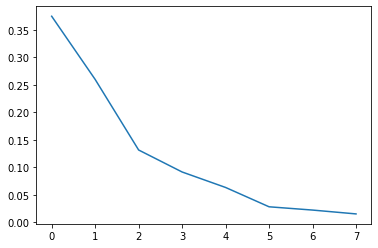

array([3.74442407e-01, 2.59742555e-01, 1.31593622e-01, 9.16514730e-02,
       6.35354417e-02, 2.84450951e-02, 2.24996402e-02, 1.55092849e-02,
       7.75151938e-03, 1.41001060e-03, 1.29544694e-03, 4.95385133e-04,
       4.25560874e-04, 3.05632251e-04, 2.45593193e-04, 2.15670925e-04,
       9.68049297e-05, 6.51079710e-05, 5.76354636e-05, 4.45650490e-05,
       3.11143077e-05, 2.97853181e-05, 2.16445934e-05, 1.24389351e-05,
       1.02427252e-05, 9.60806537e-06, 8.87263647e-06, 8.13570446e-06,
       6.97132161e-06, 5.52759663e-06, 4.86530011e-06, 4.65038152e-06])

In [3]:
## Reduce column dimensionality as the 128 columns are extremely sparse
visualize_pca = PCA().fit(scaled)

plt.plot(visualize_pca.explained_variance_ratio_[0:8])
plt.show()

visualize_pca.explained_variance_ratio_[0:32]

In [4]:
## Perform PCA with dimensionality reduction on first 32 principal components
pca = PCA(n_components=32)
scaled_pca = pca.fit_transform(scaled)

## Model Training (by window)

Since we saw that PCA gives decent improvements, we will run a sliding window over the already existing reduced dataset.

In [7]:
window_size = 6
windows = []

## Make Windows
windows = np.array([scaled_pca[row:row+window_size] for row in range(scaled_pca.shape[0]-window_size)])
print('Object: windows\nSize:', sys.getsizeof(windows)/1000000000, 'GiB')

Object: windows
Size: 0.921590912 GiB


In [18]:
x_train = tf.convert_to_tensor(windows[normal_idx[normal_idx<400000]].reshape(385675, 6, 32, 1), dtype=np.float32) # train first 80'000 rows
print('Training after anomaly removal:', x_train.shape)

x_test_unofficial_anoms =  tf.convert_to_tensor(windows[anom_idx[anom_idx<400000]].reshape(14325, 6, 32, 1), dtype=np.float32) # for validation during training
print('x_test_unofficial_anoms:', x_test_unofficial_anoms.shape)

x_test_unofficial = tf.convert_to_tensor(windows[:400000].reshape(400000, 6, 32, 1), dtype=np.float32) # test on the same 80'000 rows
print('x_test_unofficial:', x_test_unofficial.shape)

print()

x_test = tf.convert_to_tensor(windows[400000:500000].reshape(100000, 6, 32, 1), dtype=np.float32) # test on new 16'000 rows
print('x_test:', x_test.shape)
validation = tf.convert_to_tensor(windows[500000:600000].reshape(99994, 6, 32, 1), dtype=np.float32) # validate on completely new 4'000 rows
print('validation:', validation.shape)


Training after anomaly removal: (385675, 6, 32, 1)
x_test_unofficial_anoms: (14325, 6, 32, 1)
x_test_unofficial: (400000, 6, 32, 1)

x_test: (100000, 6, 32, 1)
validation: (99994, 6, 32, 1)


In [20]:
# EXPERIMENTAL REDUCED DATA WINDOW MODEL
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
       # layers.Input(shape = (6,32,1)),
        layers.Conv2D(16, (3,3), activation='relu', padding='same'), # 
        layers.Conv2D(8, (3,3), activation='relu', padding='same')])

    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, activation='relu', padding='same'),
        layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same'),
        layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])
        #layers.Reshape((10, 32))])
      
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [21]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size = 512,
                shuffle=True,
                validation_data=(x_test_unofficial_anoms, x_test_unofficial_anoms))

Epoch 1/10
754/754 [==============================] - 31s 41ms/step - loss: 0.1602 - val_loss: 0.0869
Epoch 2/10
754/754 [==============================] - 30s 39ms/step - loss: 0.0855 - val_loss: 0.0869
Epoch 3/10
754/754 [==============================] - 26s 34ms/step - loss: 0.0855 - val_loss: 0.0869
Epoch 4/10
754/754 [==============================] - 30s 40ms/step - loss: 0.0855 - val_loss: 0.0869
Epoch 5/10
754/754 [==============================] - 30s 40ms/step - loss: 0.0855 - val_loss: 0.0869
Epoch 6/10
754/754 [==============================] - 26s 34ms/step - loss: 0.0855 - val_loss: 0.0869
Epoch 7/10
754/754 [==============================] - 30s 39ms/step - loss: 0.0855 - val_loss: 0.0869
Epoch 8/10
754/754 [==============================] - 26s 34ms/step - loss: 0.0855 - val_loss: 0.0869
Epoch 9/10
754/754 [==============================] - 30s 40ms/step - loss: 0.0856 - val_loss: 0.0869
Epoch 10/10
754/754 [==============================] - 25s 34ms/step - loss: 0.085

## Model Evaluation

To evaluate models we'll first encode a set of data, decode it, then measure the loss between the original data and decoded data.

The losses will then be converted to binary to represent a prediction key of either normal or anomalous events. This will require a threshold for anomalies which we can compute using the mean and standard deviation of losses from the training set without anomalies.

Using the converted prediction key, we can directly compare it to the real anomaly key to get benchmarks. Our anomaly keys are:
- unofficial_test_key (original training window)
- official_test_key (new testing window)
- validation_key (never before seen testing window)

Let's start by getting our threshold hyperparameter:

1. Use x_train to create normal event reconstructions
2. Compute the losses
3. Get average and standard deviation of losses
4. Set threshold to be almost 2 std > mean loss


In [130]:
# Threshold function on reduced windowed data
normal_reconstructions = autoencoder.predict(x_train)

train_loss = tf.keras.losses.mae(normal_reconstructions, x_train)

avg_train_loss = np.mean(np.sum(train_loss, axis=2)) # the mean of summed error across rows 
std_train_loss = np.std(np.sum(test_loss, axis=2)) # the std of summed error across rows

threshold = avg_train_loss + std_train_loss*1.880794 

print('Mean Loss :', avg_train_loss, '\nStd Loss :', std_train_loss, '\n\nThreshold for Anomalies (rounded) :', threshold)

## Define a function for converting the losses to binary
## Any loss > threshold = anomaly
loss_to_prediction = np.vectorize(lambda loss: 1 if (loss>threshold) else 0)

Mean Loss : 2.7365532 
Std Loss : 0.3630454 

Threshold for Anomalies (rounded) : 3.4193667916926147


In [140]:
### WINDOWED PCA DATA
print('REDUCED WINDOWED DATA')

## Make windowed predictions on x_test_unofficial
test_reconstructions = autoencoder.predict(x_test)
test_loss_6x32 = tf.keras.losses.mae(test_reconstructions, x_test).numpy()

## Take mean of each row in each window
test_loss_6x1 = np.sum(test_loss_6x32, axis=2)
## Convert test_loss to anomaly predictions
prediction_windows =  loss_to_prediction(test_loss_6x1)

## Convert windowed predictions to array
predictions = np.array([(1 if
    sum(np.diagonal(np.fliplr(prediction_windows[row:row+window_size])))==window_size else 0)
    for row in range(len(prediction_windows)-window_size)])

key = official_test_key[:-window_size]

## Benchmarcks
print(confusion_matrix(key, predictions), end = '\n\n')
print('Accuracy:', round(accuracy_score(key, predictions), 4)) # of all predictions, how many were correct?
print('Precision:', round(precision_score(key, predictions), 4)) # of predicted anomalies, how many were correct?
print('Recall:', round(recall_score(key, predictions), 4)) # of all true anomalies, how many were recovered?

[[74705 20519]
 [ 3758  1012]]

Accuracy: 0.7572
Precision: 0.047
Recall: 0.2122


The issue here is, the errors look exactly like the normal messages. To find errors, we need a feature that captures the order of message groups within a specific type of block ID. For example, a block ID that was received cannot be in a state of receiving after being received. Thus we need to organize our data around the unique block IDs and to model their sequences.

Let's try a more basic autoencoder that flattens all the data.

In [171]:
# REDUCED DATA WINDOW MODEL --> precidion of almost 30% on window of 6
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu')])

    self.decoder = tf.keras.Sequential([
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(192, activation='sigmoid'),
        layers.Reshape((6, 32))])
      
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [142]:
x_train = tf.convert_to_tensor(windows[normal_idx[normal_idx<400000]], dtype=np.float32) 
print('Training after anomaly removal:', x_train.shape)

x_test_unofficial_anoms =  tf.convert_to_tensor(windows[anom_idx[anom_idx<400000]], dtype=np.float32) 
print('x_test_unofficial_anoms:', x_test_unofficial_anoms.shape)

x_test_unofficial = tf.convert_to_tensor(windows[:400000], dtype=np.float32) 
print('x_test_unofficial:', x_test_unofficial.shape)

print()

x_test = tf.convert_to_tensor(windows[400000:500000], dtype=np.float32) 
print('x_test:', x_test.shape)
validation = tf.convert_to_tensor(windows[500000:600000], dtype=np.float32) #
print('validation:', validation.shape)

Training after anomaly removal: (385675, 6, 32)
x_test_unofficial_anoms: (14325, 6, 32)
x_test_unofficial: (400000, 6, 32)

x_test: (100000, 6, 32)
validation: (99994, 6, 32)


In [172]:
autoencoder.fit(x_train, x_train,
                epochs=8,
                batch_size = 512,
                shuffle=True,
                validation_data=(x_test_unofficial_anoms, x_test_unofficial_anoms))

Epoch 1/8
754/754 [==============================] - 11s 14ms/step - loss: 0.1876 - val_loss: 0.0870
Epoch 2/8
754/754 [==============================] - 14s 18ms/step - loss: 0.0855 - val_loss: 0.0869
Epoch 3/8
754/754 [==============================] - 10s 13ms/step - loss: 0.0855 - val_loss: 0.0869
Epoch 4/8
754/754 [==============================] - 9s 12ms/step - loss: 0.0854 - val_loss: 0.0867
Epoch 5/8
754/754 [==============================] - 9s 12ms/step - loss: 0.0852 - val_loss: 0.0866
Epoch 6/8
754/754 [==============================] - 9s 12ms/step - loss: 0.0852 - val_loss: 0.0861
Epoch 7/8
754/754 [==============================] - 9s 12ms/step - loss: 0.0846 - val_loss: 0.0858
Epoch 8/8
754/754 [==============================] - 9s 12ms/step - loss: 0.0842 - val_loss: 0.0853


In [173]:
# Threshold function on reduced windowed data
normal_reconstructions = autoencoder.predict(x_train)

train_loss = tf.keras.losses.mae(normal_reconstructions, x_train)

avg_train_loss = np.mean(np.mean(train_loss, axis=0)) # the mean row error // float(tf.math.reduce_mean(train_loss))
std_train_loss = np.mean(np.std(train_loss, axis=0)) # the std of row error // float(tf.math.reduce_std(train_loss))

threshold = avg_train_loss + std_train_loss*1.880794 # for 97% of data

print('Mean Loss :', avg_train_loss, '\nStd Loss :', std_train_loss, '\n\nThreshold for Anomalies :', threshold)

## Define a function for converting the losses to binary
## Any loss > threshold = anomaly
loss_to_prediction = np.vectorize(lambda loss: 1 if (loss>threshold) else 0)

Mean Loss : 0.083813615 
Std Loss : 0.011368076 

Threshold for Anomalies : 0.10519462487187796


In [174]:
### WINDOWED PCA DATA
print('REDUCED WINDOWED DATA\n')

## Make windowed predictions on x_test
test_reconstructions = autoencoder.predict(x_test)
test_loss = tf.keras.losses.mae(test_reconstructions, x_test).numpy()

## Convert test_loss to anomaly predictions
prediction_windows =  loss_to_prediction(test_loss)

## Convert windowed predictions to array
predictions = np.array([(1 if
    sum(np.diagonal(np.fliplr(prediction_windows[row:row+window_size])))==window_size else 0)
    for row in range(len(prediction_windows)-window_size)])

key = official_test_key[:-window_size]

## Benchmarcks
print(confusion_matrix(key, predictions), end = '\n\n')
print('Accuracy:', round(accuracy_score(key, predictions), 4)) # of all predictions, how many were correct?
print('Precision:', round(precision_score(key, predictions), 4)) # of predicted anomalies, how many were correct?
print('Recall:', round(recall_score(key, predictions), 4)) # of all true anomalies, how many were recovered?

REDUCED WINDOWED DATA

[[71026 24198]
 [ 3596  1174]]

Accuracy: 0.722
Precision: 0.0463
Recall: 0.2461


### Visualizing the Reconstruction Loss

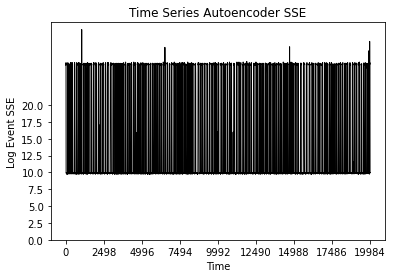

Std of event SSE :  8.600297 
Mean of event SSE :  17.764029 
4 std :  34.401187896728516


In [138]:
encoded_frames = autoencoder.encoder(x_test).numpy()
decoded_frames = autoencoder.decoder(encoded_frames).numpy()

sse_per_encoding = tf.math.reduce_sum(tf.math.square(x_test - decoded_frames), axis = [1,2])


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure()
ax = plt.axes()
l, u = 0, 19990
stp = int((u-l)/8)

ax.plot(sse_per_encoding[l:u], c = 'black', lw = 1)
ax.set_yticks(np.arange(0,22,2.5))
ax.set_xticks(np.arange(0,u-l,stp))
ax.set_xlabel('Time')
ax.set_ylabel('Log Event SSE')
ax.set_title('Time Series Autoencoder SSE')
plt.show()

print('Std of event SSE : ', np.std(sse_per_encoding), '\nMean of event SSE : ', np.mean(sse_per_encoding), '\n4 std : ', 4*np.std(sse_per_encoding))